In [1]:
import pandas as pd
import geopandas as gpd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.tools.tools import add_constant
import numpy as np
import statsmodels.api as sm

/Users/Salim/Library/Python/3.8/lib/python/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Load data

Load dataset with snapshot of 2014 pipeline snapshot and outcomes.

In [2]:
mv_history = pd.read_csv('./data/pipeline_history.csv')

The variable 'Built' indicates how much of the project was built by June 2022. The variable 'Units' indicates how large the project was as of June 2014 - or, if the project had no size listed in 2014, then the eventual size of the project. The variable 'Pg' indicates what page of the (2014 Planning Division Update)[https://web.archive.org/web/20140709150825/http://mountainview.gov/civicax/filebank/blobdload.aspx?BlobID=13170 ] the project is listed on. 

In [3]:
mv_history.head()

,Address,Pg,Built,Units
0,420 San Antonio,3,1.00,373
1,2580 California St,4,0.26,632
2,1701 ECR,7,1.00,24
3,1101 ECR,8,1.00,52
4,801 ECR,8,1.00,164


Load site inventory datasets.

In [4]:
si_geo = gpd.read_file('./data/MV_Site_Inventory/MV_Site_Inventory.shp')

In [5]:
si = pd.read_csv('./data/hcd_table_a.csv', low_memory=False)
si = si[~si.isna().all(axis=1)]
si = si[:-1]

In [6]:
permits = gpd.read_file('./data/all_permits.json')

In [7]:
zoning = gpd.read_file('./data/Zoning_Districts/Zoning_Districts.shp')

### Pending Projects History Analysis

In [8]:
sum(mv_history.Units * mv_history.Built) / mv_history.Units.sum()

0.6719286871961102

In [9]:
pearsonr(mv_history.Units, mv_history.Built)

(-0.24156975644156864, 0.3048589611212049)

### Pending Projects Predictions

In [13]:
np.random.seed(1)
reg = sm.Logit(mv_history.Built, add_constant(mv_history.Units)).fit_regularized()

def predict_success(n_units):
    """P(devs) adjusted for number of units in project."""
    return reg.predict([1, n_units])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4578744955743205
            Iterations: 50
            Function evaluations: 480
            Gradient evaluations: 50


In [14]:
def predict_success_floor(n_units):
    """
    P(devs) adjusted for number of units in project, with a floor that 
    pipeline sites are at least as likely to be developed as opportunity sites.
    """
    return max(reg.predict([1, n_units]), .206)

In [15]:
pipeline = si[si['Optional Information 1'].str.contains('Pending')]

This dataset excludes approved projects, which is why it has less total capacity than the draft claims.

In [16]:
pipeline['Total Capacity'].sum()

6913.0

In [17]:
pipeline['Site Status'].value_counts()

Pending Project    66
Name: Site Status, dtype: int64

#### Pipeline capacity with plain Logistic Regression

In [24]:
p_devs = pipeline['Total Capacity'].apply(predict_success)

In [25]:
sum(p_devs * pipeline['Total Capacity']).item()

2114.4157200269683

In [26]:
sum(p_devs * pipeline['Lower Income Capacity']).item()

919.6555947279619

#### Pipeline capacity with constraint that P(dev | pipeline) > P(dev | opp) for all sites

In [27]:
p_devs = pipeline['Total Capacity'].apply(predict_success_floor)

In [28]:
sum(p_devs * pipeline['Total Capacity']).item() 

2804.1691536696494

In [29]:
sum(p_devs * pipeline['Lower Income Capacity']).item()

1027.8843652965609

### Opportunity Sites

In [30]:
opps = si[~si['Site Status'].str.contains('Pending')]

In [31]:
opps['Zoning Designation (Current)'].value_counts()

P(38) - El Camino Real Precise Plan    55
P(41) - East Whisman Precise Plan      15
P(40) - San Antonio Precise Plan        9
P(39) - North Bayshore Precise Plan     6
CN                                      5
CRA                                     4
P(27) - Grant-Phyllis Precise Plan      2
P(19) - Downtown Precise Plan           1
Name: Zoning Designation (Current), dtype: int64

Find opportunity sites for each of four major precise plan areas.

In [32]:
ecr = opps[opps['Zoning Designation (Current)'].str.contains("El Camino Real")]

In [33]:
ew = opps[opps['Zoning Designation (Current)'].str.contains("East Whisman")]

In [34]:
sa = opps[opps['Zoning Designation (Current)'].str.contains("San Antonio")]

In [35]:
nb = opps[opps['Zoning Designation (Current)'].str.contains("North Bayshore")]

There are 55 opportunity sites in El Camino Real Precise Plan, 15 in the East Whisman precise plan, 9 in the San Antonio precise plan, and 6 in the North Bayshore precise plan.

In [36]:
len(ecr), len(ew), len(sa), len(nb)

(55, 15, 9, 6)

### Cleaning permits dataset

Half of older permits have same geometry.

In [37]:
permits.apn = permits.apn.str.split('-').str.join('')

In [38]:
permits.apn = permits.apn.str.replace('Â\xa0', '').values.tolist()

In [39]:
permits.apn = permits.apn.str.strip()

In [40]:
permits = permits[(~permits.apn.duplicated()) | (permits.apn.isnull())]

In [41]:
permits = gpd.sjoin(permits, zoning.to_crs('EPSG:4326'))

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2018. , 2018.3, 2018.6, 2018.9, 2019.2, 2019.5, 2019.8, 2020.1,
        2020.4, 2020.7, 2021. ]),
 <BarContainer object of 10 artists>)

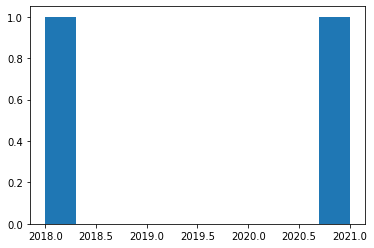

In [42]:
plt.hist(permits[permits.PRECPLAN == 'P(39)'].permyear)

In [43]:
pp_permits = permits['PRECPLAN'].value_counts()

In [44]:
ecr_ppid = 'P(38)'
nbs_ppid = 'P(39)'
sa_ppid = 'P(40)'
ew_ppid = 'P(41)'

In [46]:
ecr_yrs, ew_yrs, sa_yrs, nbs_yrs = 8, 3, 8, 5

In [47]:
ecr_exp = pp_permits[ecr_ppid] / ecr_yrs * 8

In [48]:
pp_permits[ecr_ppid] / ecr_yrs

3.125

In [49]:
nbs_exp = pp_permits[nbs_ppid] / nbs_yrs * 8

In [50]:
pp_permits[nbs_ppid] / nbs_yrs

0.4

In [51]:
sa_exp = pp_permits[sa_ppid] / sa_yrs * 8

In [52]:
pp_permits[sa_ppid] / sa_yrs

0.875

In [53]:
ew_exp = pp_permits[ew_ppid] / ew_yrs * 8

In [54]:
pp_permits[ew_ppid] / ew_yrs

0.6666666666666666

In [55]:
for pp, name, expect in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb'], [ecr_exp, ew_exp, sa_exp, nbs_exp]):
    print('For', name, 'the city claims', len(pp), 'projects in 8 years', ' but historical trends suggest')
    print(int(round(expect, 0)), "is more reasonable. That'd discount their site capacity claims by", round(1 - (int(round(expect,0)) / len(pp)), 2), '%')
    print('\n')

For ecr the city claims 55 projects in 8 years  but historical trends suggest
25 is more reasonable. That'd discount their site capacity claims by 0.55 %


For ew the city claims 15 projects in 8 years  but historical trends suggest
5 is more reasonable. That'd discount their site capacity claims by 0.67 %


For sa the city claims 9 projects in 8 years  but historical trends suggest
7 is more reasonable. That'd discount their site capacity claims by 0.22 %


For nb the city claims 6 projects in 8 years  but historical trends suggest
3 is more reasonable. That'd discount their site capacity claims by 0.5 %




In [56]:
for pp, name, expect in zip([ecr, ew, sa, nb], ['ecr', 'ew', 'sa', 'nb'], [ecr_exp, ew_exp, sa_exp, nbs_exp]):
    print('For', name, 'the city claims', len(pp), 'projects in 8 years, but historical trends suggest')
    print(int(round(expect, 0)), "is more reasonable. That'd inflate their site capacity claims by", 
          int(round(round(len(pp) / expect, 3)*100 - 100, 0)), '%')
    print('\n')

For ecr the city claims 55 projects in 8 years, but historical trends suggest
25 is more reasonable. That'd inflate their site capacity claims by 120 %


For ew the city claims 15 projects in 8 years, but historical trends suggest
5 is more reasonable. That'd inflate their site capacity claims by 181 %


For sa the city claims 9 projects in 8 years, but historical trends suggest
7 is more reasonable. That'd inflate their site capacity claims by 29 %


For nb the city claims 6 projects in 8 years, but historical trends suggest
3 is more reasonable. That'd inflate their site capacity claims by 88 %




In [74]:
ecr_li, ecr_tot = 1283, 2530
ew_li, ew_tot = 997, 1312
sa_li, sa_tot = 182, 325
nb_li, nb_tot = 313, 405
run_sum_li, run_sum_tot = 0, 0

In [75]:
for pp, name, expect, li, tot in zip([ecr, ew, sa, nb], 
                                ['ecr', 'ew', 'sa', 'nb'], 
                                [ecr_exp, ew_exp, sa_exp, nbs_exp],
                                [ecr_li, ew_li, sa_li, nb_li],
                                [ecr_tot, ew_tot, sa_tot, nb_tot]):
    print('For', name, li*(1 - expect / len(pp)))
    print('\n')
    print('For', name, tot*(1 - expect / len(pp)))
    print('\n')
    run_sum_li += li*(1 - expect / len(pp))
    run_sum_tot += tot*(1 - expect / len(pp))

For ecr 699.8181818181818


For ecr 1380.0


For ew 642.5111111111112


For ew 845.5111111111112


For sa 40.44444444444444


For sa 72.22222222222221


For nb 146.06666666666666


For nb 189.0




In [62]:
run_sum_li

1528.8404040404039

In [63]:
run_sum_tot

2486.733333333333

In [70]:
5502 - run_sum_tot

3015.266666666667

In [71]:
3240 - run_sum_li

1711.1595959595961

In [69]:
2775 + 465


3240

In [68]:
4698 + 804

5502